In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

# Prepare Data

In [38]:
data_dir = "../data/Jan1524_Jan2224/"
data_files = [file for file in os.listdir(data_dir) if file.endswith(".csv")]
data = []
for file in data_files:
    df = pd.read_csv(data_dir + file, index_col=0)
    df.loc[df["pm25"] < 0, 'pm25'] = 0
    data.append(df.loc[:, ['pm25', 'longitude', 'latitude']].to_numpy())
data = np.array(data).transpose(1, 0, 2)
X = data[:, :, 1:]
Y = data[:, :, 0]
print(X.shape, Y.shape)

(10082, 8, 2) (10082, 8)


# Interpolation Algorithm

In [39]:
class IDW:
    def __init__(self, X, Y):
        """
        X: (n, d), n is the number of samples, d is the dimension of feature vectors
        Y: (n, ), n is the number of samples
        """
        self.X = X
        self.Y = Y

    def predict(self, X_test, p=2):
        """
        X_test: (m, d), m is the number of test samples, d is the dimension of feature vectors
        p: the power of distance
        """
        # construct distance matrix
        dist_matrix = np.zeros((X_test.shape[0], self.X.shape[0]))
        for i in range(X_test.shape[0]):
            for j in range(self.X.shape[0]):
                dist = np.linalg.norm(X_test[i] - self.X[j])
                dist_matrix[i, j] = dist
        
        # construct weight matrix
        weight_matrix = 1 / np.power(dist_matrix, p)

        # normalize weight matrix
        weight_matrix = weight_matrix / np.sum(weight_matrix, axis=1, keepdims=True)
        self.weight_matrix = weight_matrix

        # predict
        Y_pred = np.matmul(weight_matrix, self.Y)
        return Y_pred


# LOOCV

In [40]:
n_steps = X.shape[0]
n_stations = X.shape[1]

In [41]:
RMSEs = []
MAEs = []
for t in range(n_steps):
    for i in range(n_stations):
        X_train = np.concatenate((X[t, :i], X[t, i+1:]), axis=0)
        X_test = X[t, i:i+1]
        Y_train = np.concatenate((Y[t, :i], Y[t, i+1:]), axis=0)
        Y_test = Y[t, i:i+1]
        idw = IDW(X_train, Y_train)
        Y_pred = idw.predict(X_test)
        rmse = np.sqrt(np.mean(np.square(Y_pred - Y_test)))
        mae = np.mean(np.abs(Y_pred - Y_test))
        RMSEs.append(rmse)
        MAEs.append(mae)

In [42]:
print("RMSE: ", np.mean(RMSEs), "Standard Deviation: ", np.std(RMSEs))
print("MAE: ", np.mean(MAEs), "Standard Deviation: ", np.std(MAEs))

RMSE:  2.040437611779065 Standard Deviation:  2.1142197199666475
MAE:  2.040437611779065 Standard Deviation:  2.1142197199666475


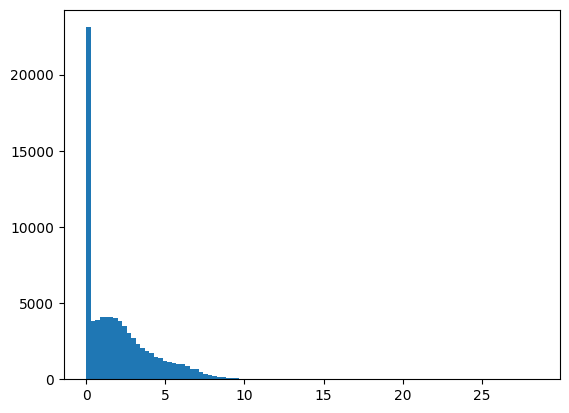

In [43]:
plt.hist(RMSEs, bins=100)
plt.show()